In [30]:
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.master('local').getOrCreate()

ConnectionRefusedError: [Errno 61] Connection refused

In [29]:
spark.sparkContext.stop()

ConnectionRefusedError: [Errno 61] Connection refused

In [3]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, roc_curve, precision_score
from sklearn.preprocessing import MinMaxScaler

# Dataset

Make dataframe with 4 different cases

In [20]:
start_date = '2019-01-01'
end_date = '2023-12-31'

date_range = pd.date_range(start=start_date, end=end_date, freq='M')
df1 = pd.DataFrame({'ds': date_range, 'y': 0})
df1['Case'] = 1
df2 = pd.DataFrame({'ds': date_range, 'y': 0})
df2['Case'] = 2
df3 = pd.DataFrame({'ds': date_range, 'y': 0})
df3['Case'] = 3
df4 = pd.DataFrame({'ds': date_range, 'y': 0})
df4['Case'] = 4
dfs = [df1, df2, df3, df4]

# Create a column for the month and day
for i, df in enumerate(dfs):
    dfs[i]['year'] = df['ds'].dt.year
    dfs[i]['month'] = df['ds'].dt.month

# Set the y value to 1000000 for months 6 and 12
df1.loc[(df1['month'] == 6) | (df1['month'] == 12), 'y'] = np.random.normal(loc=1000000, scale=300000, size=10)
df2.loc[(df2['month'] == 3) | (df2['month'] == 9), 'y'] = np.random.normal(loc=10000000, scale=3000000, size=10)
df3.loc[(df3['month'] == 2) | (df3['month'] == 8), 'y'] = np.random.normal(loc=4200000, scale=300000*4.2, size=10)
df4.loc[(df4['month'] == 5) | (df4['month'] == 11), 'y'] = np.random.normal(loc=4200000/69, scale=300000*4.2/69, size=10)


for i, df in enumerate(dfs):
    dfs[i] = df.drop(['year', 'month'], axis=1)
    dfs[i]['ds'] = dfs[i]['ds'].dt.strftime('%Y-%m-%d')

# Append dfs
df = pd.concat(dfs)
df.tail()

,ds,y,Case
55,2023-08-31,1.000000,4
56,2023-09-30,1.000000,4
57,2023-10-31,1.000000,4
58,2023-11-30,60928.417905,4
59,2023-12-31,1.000000,4


In [21]:
train_end = '2022-12-31'
test_start = '2023-01-01'

# Convert the date columns to datetime format
df['ds'] = pd.to_datetime(df['ds'])

# Split the dataframe into train and test sets
train_df = df.loc[(df['ds'] <= train_end)]
test_df = df.loc[df['ds'] >= test_start]

# Reset the indices of the new dataframes
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df.head()

,ds,y,Case
0,2023-01-31,1.0,1
1,2023-02-28,1.0,1
2,2023-03-31,1.0,1
3,2023-04-30,1.0,1
4,2023-05-31,1.0,1


# Fit Test

Test fitting and getting results normally using pandas apply

In [22]:
unique_values = df['Case'].unique()
s = pd.Series(unique_values)
print(s)


0    1
1    2
2    3
3    4
dtype: int64


15:13:15 - cmdstanpy - INFO - Chain [1] start processing
15:13:15 - cmdstanpy - INFO - Chain [1] done processing


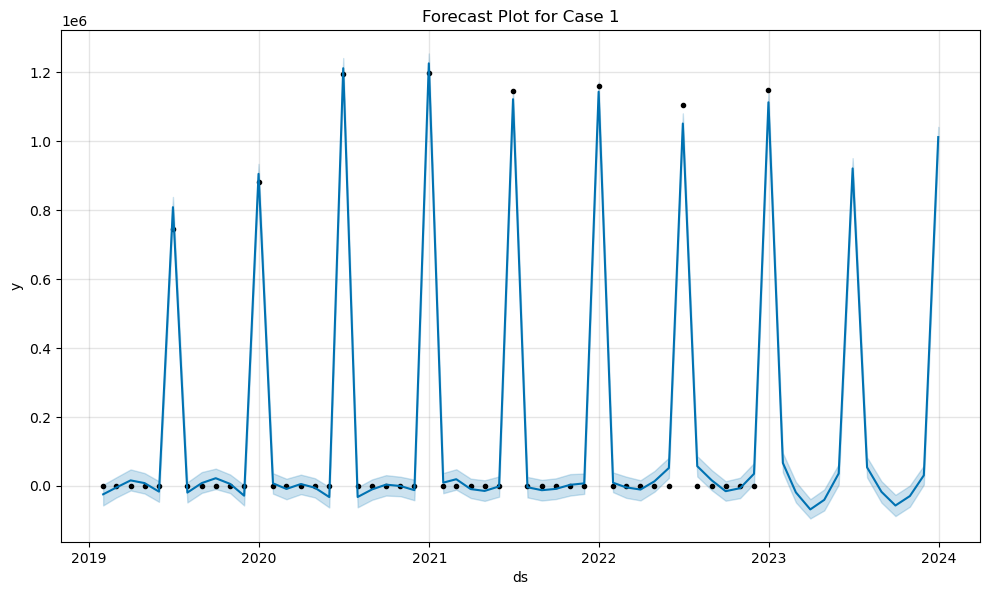

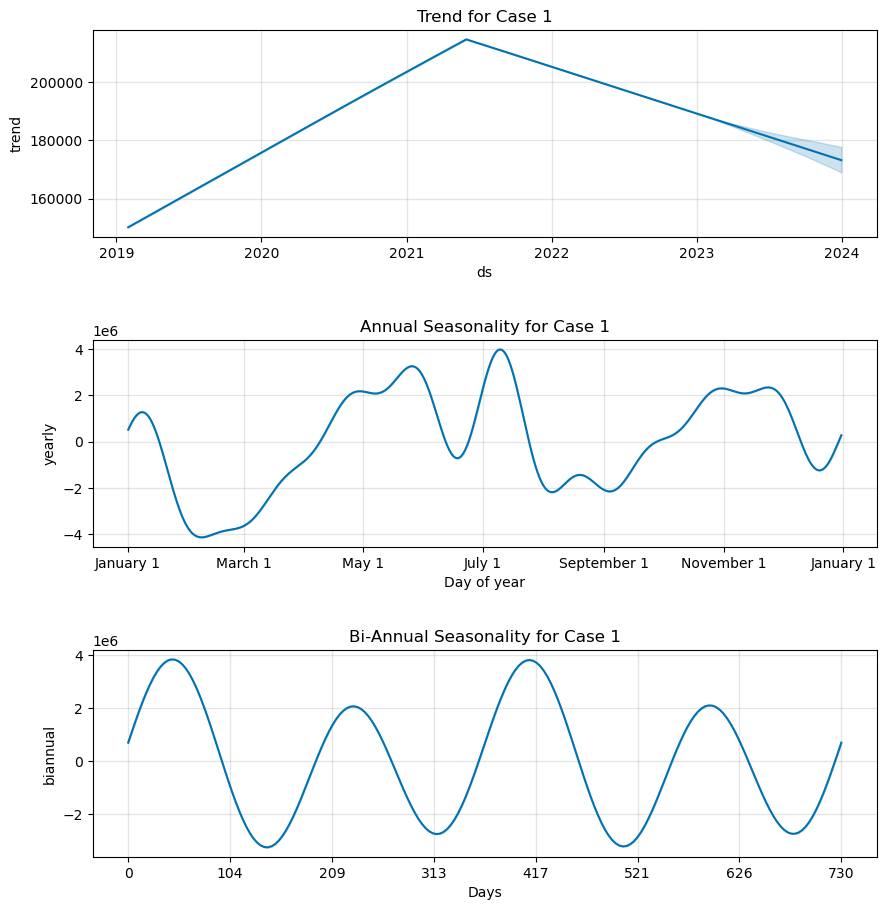

In [25]:
# Write function to run model
def runProphet(case, train_dfs):
    train_df = train_dfs.loc[train_dfs['Case'] == case]
    train_df = train_df.drop(columns=['Case'])
    m = Prophet(weekly_seasonality=False)
    m.add_seasonality(name='biannual', period=365*2, fourier_order=5)
    m.fit(train_df)
    future = m.make_future_dataframe(periods=12, freq = 'M')
    forecast = m.predict(future)
    fig1 = m.plot(forecast)
    s = "Forecast Plot for Case "+str(case)
    plt.title(s)
    fig2 = m.plot_components(forecast)
    plt.subplots_adjust(hspace=0.5)
    ax1, ax2, ax3 = fig2.get_axes()
    ax1.set_title("Trend for Case "+str(case))
    ax2.set_title("Annual Seasonality for Case "+str(case))
    ax3.set_title("Bi-Annual Seasonality for Case "+str(case))

    plt.show()

runProphet(1,train_df)

Run it!

15:16:18 - cmdstanpy - INFO - Chain [1] start processing
15:16:19 - cmdstanpy - INFO - Chain [1] done processing


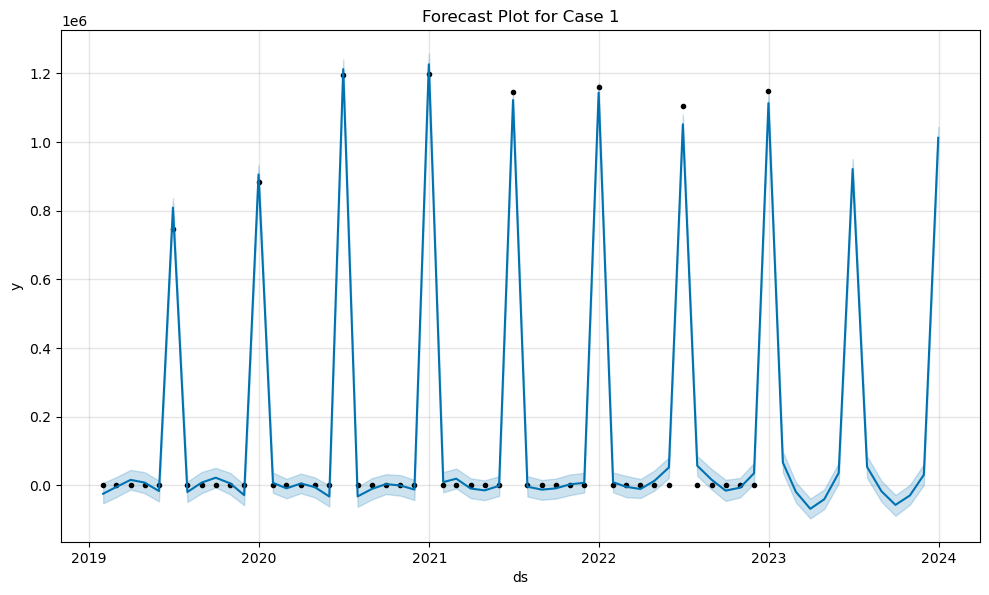

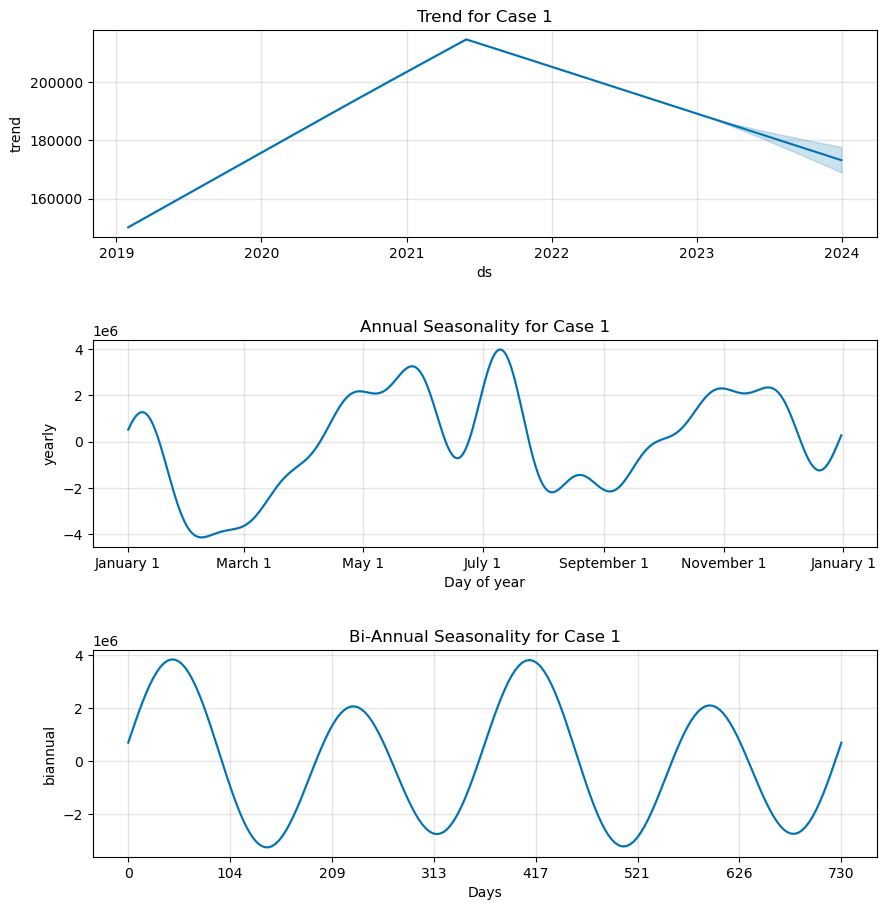

15:16:19 - cmdstanpy - INFO - Chain [1] start processing
15:16:20 - cmdstanpy - INFO - Chain [1] done processing


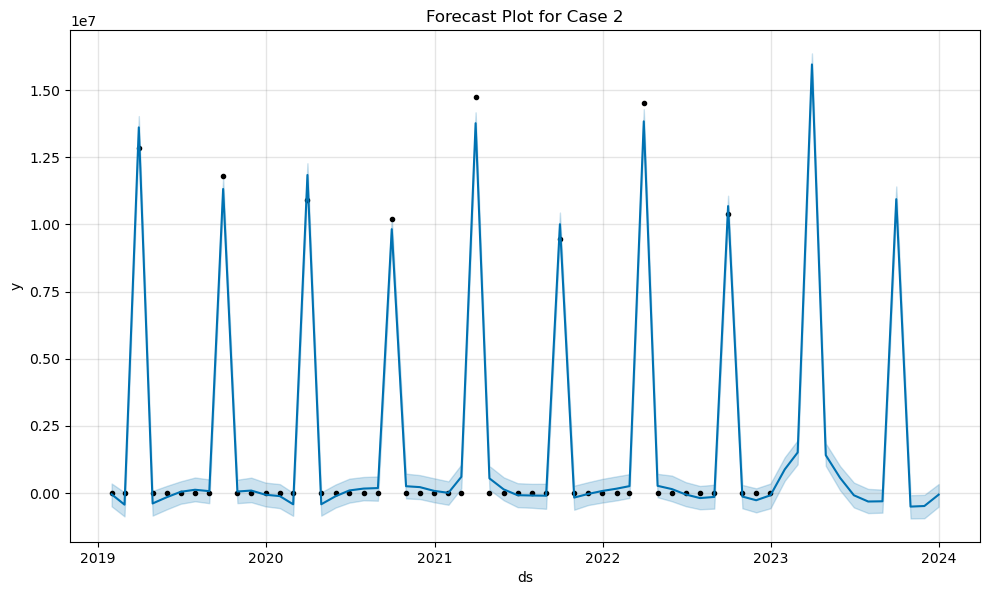

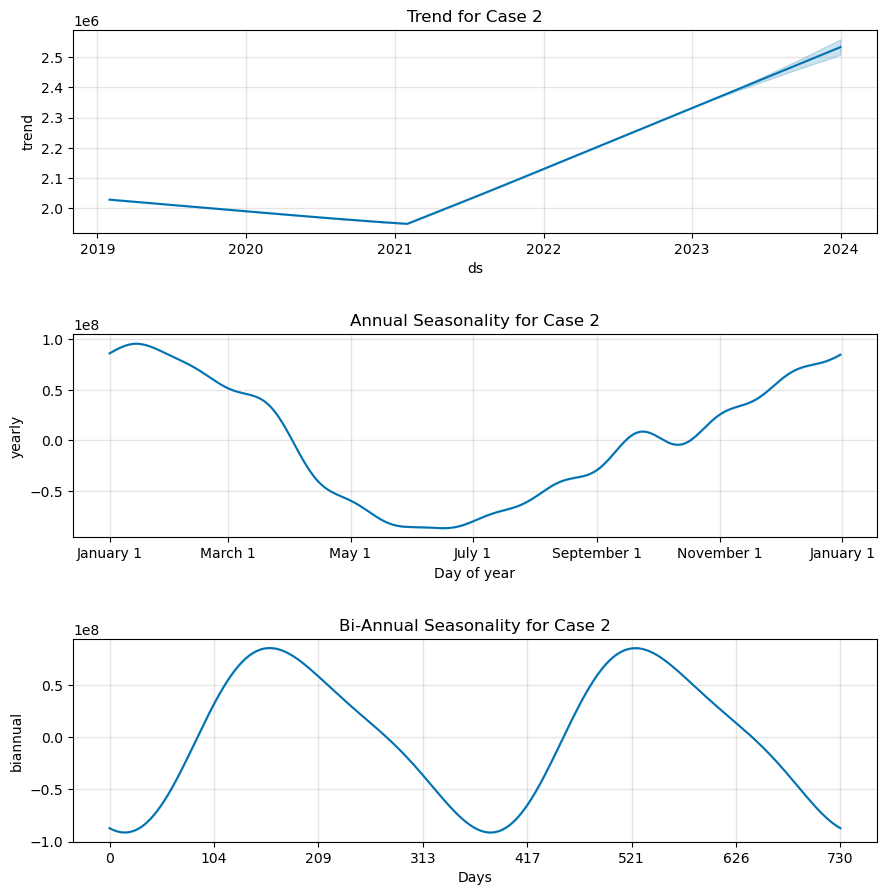

15:16:20 - cmdstanpy - INFO - Chain [1] start processing
15:16:20 - cmdstanpy - INFO - Chain [1] done processing


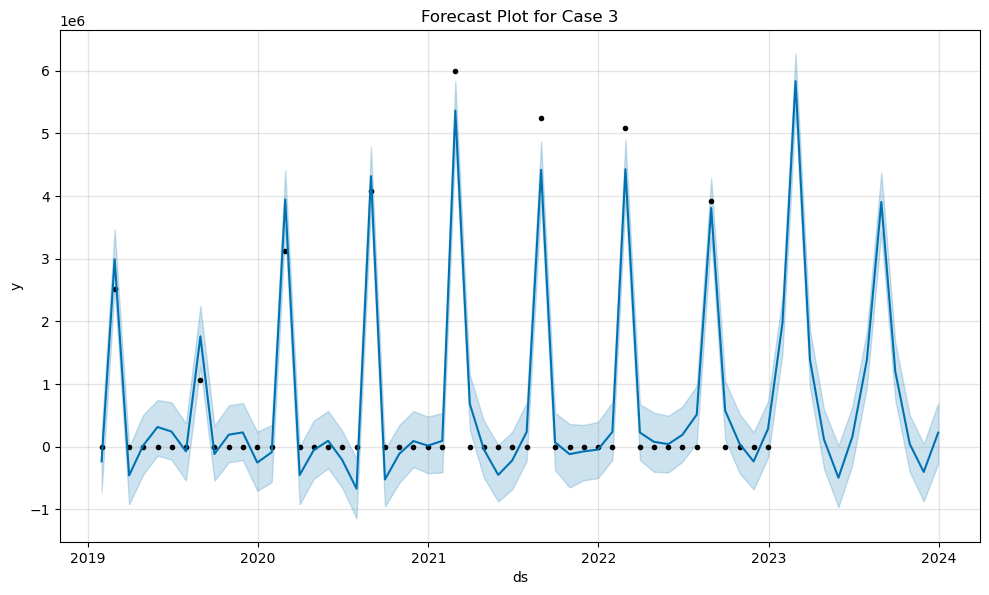

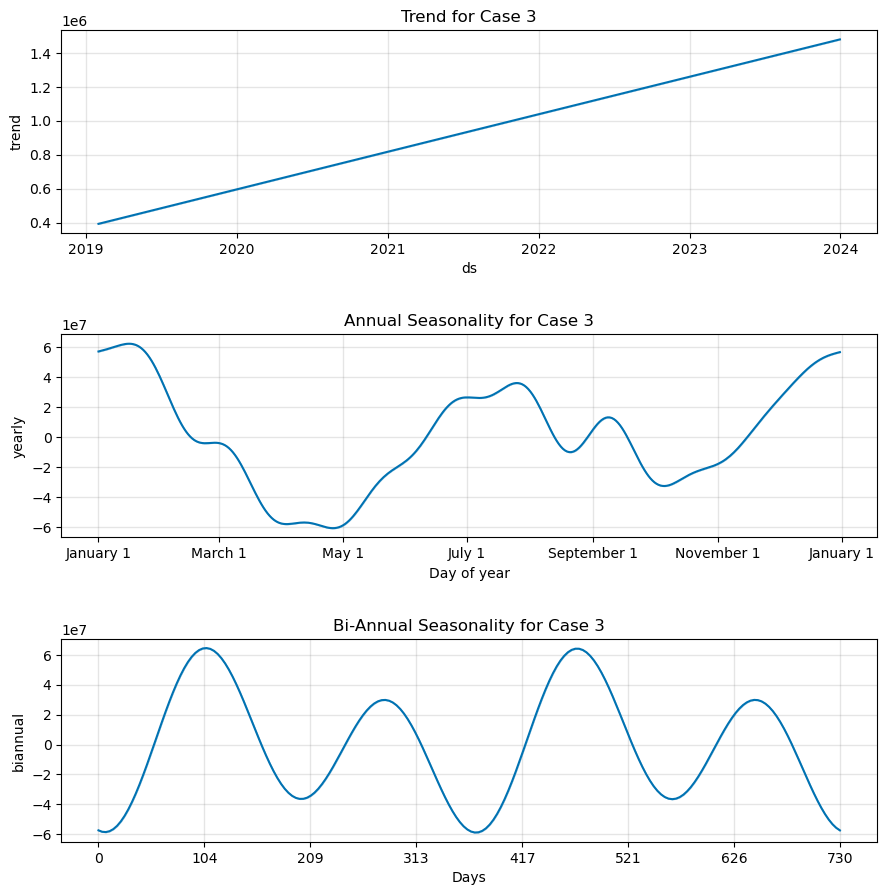

15:16:21 - cmdstanpy - INFO - Chain [1] start processing
15:16:21 - cmdstanpy - INFO - Chain [1] done processing


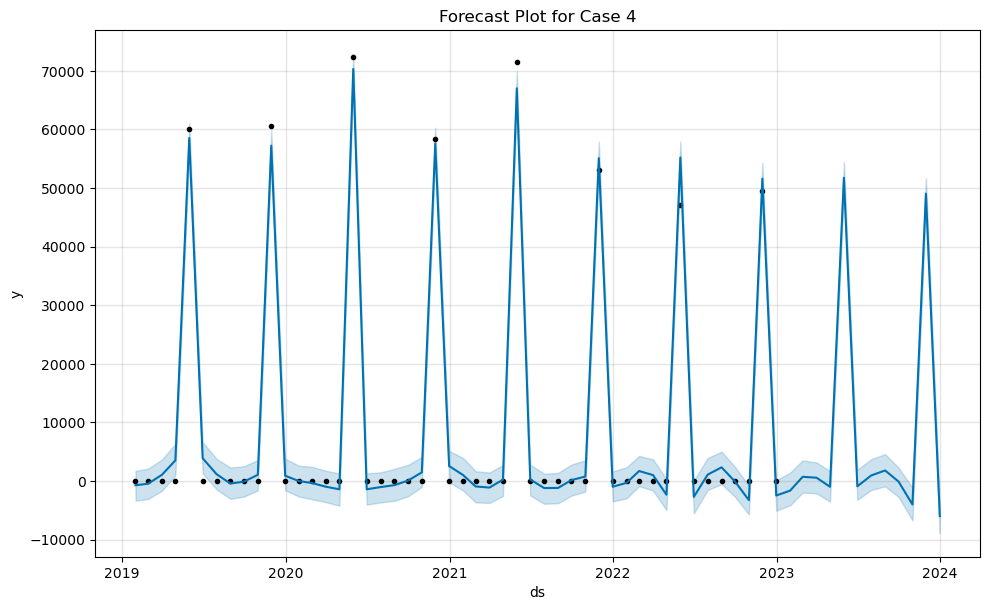

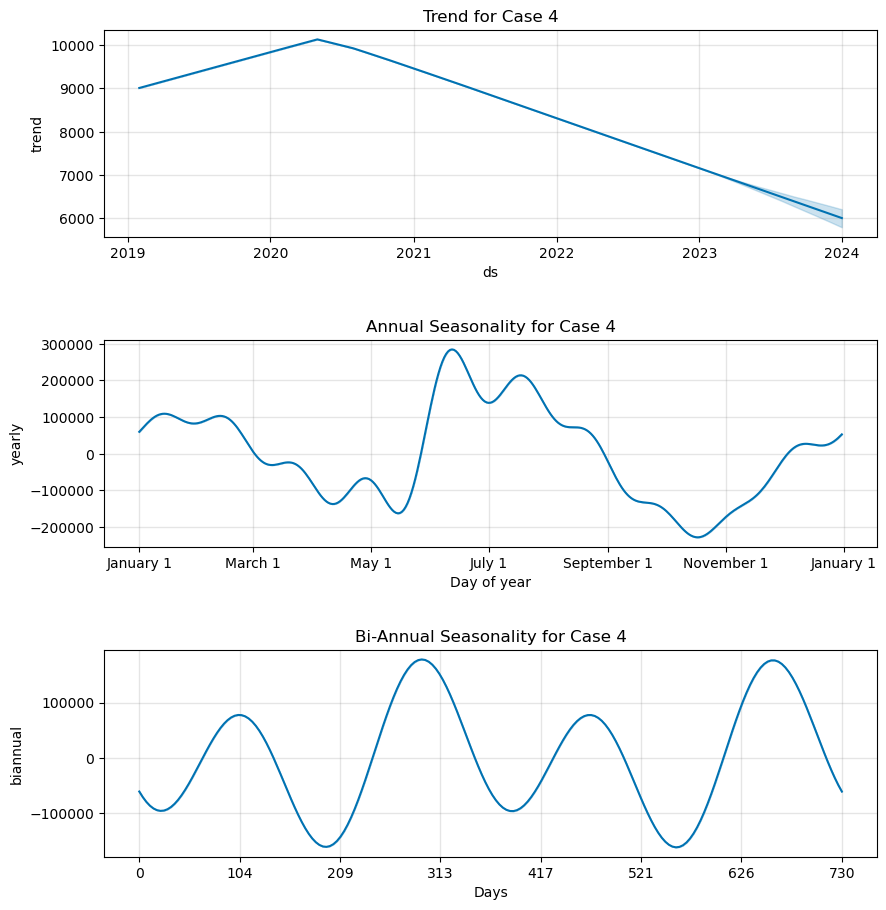

0    None
1    None
2    None
3    None
dtype: object

In [26]:
s.apply(runProphet, train_dfs = train_df)

# Pandas UDF Test

Make sure cluster enviroment is setup, import data into it, and test a simple function using Pandas UDF.

In [27]:
# Convert test and train dataframes into Spark dataframes
train_sdf = spark.createDataFrame(train_df)
train_sdf.printSchema() #data type of each col
train_sdf.show(5) #It gives you head of pandas DataFrame

test_sdf = spark.createDataFrame(test_df)
test_sdf.printSchema() #data type of each col
test_sdf.show(5) #It gives you head of pandas DataFrame

ConnectionRefusedError: [Errno 61] Connection refused